In [1]:
import flamp
import numpy as np
import numpy.linalg as lin
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import sparse
from tqdm import tqdm

import matrix_functions as mf

flamp.set_dps(50)  # compute with this many decimal digits precision


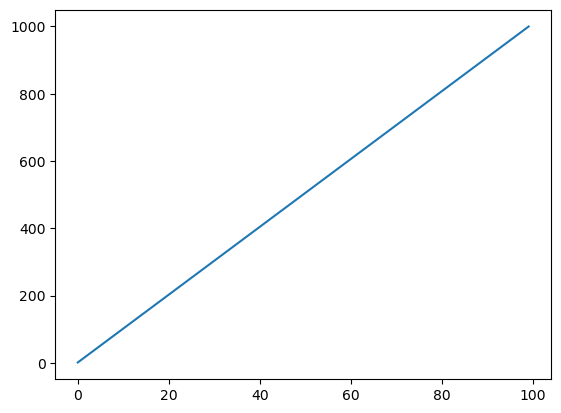

In [2]:
dim = 100
kappa = flamp.gmpy2.mpfr(1_000.)
lambda_min = flamp.gmpy2.mpfr(1.)
lambda_max = kappa * lambda_min

# a_diag = mf.flipped_model_spectrum(dim, kappa, 50, lambda_1=lambda_min)
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_size=3, lambda_1=lambda_min)
a_diag = mf.utils.linspace(lambda_min, lambda_max, num=dim)
# a_diag = mf.model_spectrum(dim, kappa, .9, lambda_1=lambda_min)
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_width=0.001, high_cluster_width=0.5, low_cluster_size=5, lambda_1=lambda_min)

A = mf.DiagonalMatrix(a_diag)
sqrtA = mf.DiagonalMatrix(flamp.sqrt(a_diag))
invA = mf.DiagonalMatrix(1./a_diag)

plt.plot(a_diag)

In [3]:
b = flamp.ones(dim)

denom_deg = 2
def f(x):
    return x**(-denom_deg)

ground_truth = mf.diagonal_fa(f, a_diag, b)

# size of Krylov subspace
ks = list(range(1,25)) + list(range(30, dim, 10))

In [4]:
def spectral_norm(X):
    return np.abs(flamp.eigh(X, eigvals_only=True)).max()

In [17]:
err2_Anorm = pd.Series(index=ks, dtype=np.float64)
opt2_err_Anorm = pd.Series(index=ks, dtype=np.float64)
lanc_vs_opt_Anorm = pd.Series(index=ks, dtype=np.float64)
one_removed_Anorm = pd.Series(index=ks, dtype=np.float64)
opt_removed_Anorm = pd.Series(index=ks, dtype=np.float64)

one_removed_submult = pd.Series(index=ks, dtype=np.float64)
opt_removed_submult = pd.Series(index=ks, dtype=np.float64)

for k in ks:
    Q, (alpha, beta) = mf.lanczos(A, b, k, reorthogonalize=True, beta_tol=flamp.to_mp("1e-20"))
    T_lambda, T_V = mf.utils.eigh_tridiagonal(alpha, beta)
    Q_TV = Q @ T_V
    T_lambda = mf.DiagonalMatrix(T_lambda)

    lanczos2 = Q_TV @ ((T_lambda ** (-denom_deg)) @ (Q_TV.transpose() @ b))
    opt2 = Q_TV @ ((T_lambda ** (-1)) @ (Q_TV.transpose() @ ((A ** (1-denom_deg)) @ b)))
 
    err2 = lanczos2 - ground_truth
    err2_Anorm.loc[k] = mf.norm(sqrtA @ err2)

    opt2_err = opt2 - ground_truth
    opt2_err_Anorm.loc[k] = mf.norm(sqrtA @ opt2_err)

    lanc_vs_opt = lanczos2 - opt2
    lanc_vs_opt_Anorm.loc[k] = mf.norm(sqrtA @ lanc_vs_opt)

    lanczos_prev = Q_TV @ ((T_lambda ** (1-denom_deg)) @ (Q_TV.transpose() @ b))
    one_removed = invA @ lanczos_prev - ground_truth
    one_removed_Anorm.loc[k] = mf.norm(sqrtA @ one_removed)
    # one_removed_mat = invA @ (Q_TV @ ((T_lambda ** (1-denom_deg)) @ Q_TV.transpose())) - np.diag((A ** (-denom_deg)).diag)
    # one_removed_submult.loc[k] = spectral_norm(sqrtA @ one_removed_mat) * mf.norm(b)
    # assert mf.norm(one_removed_mat @ b - one_removed) / mf.norm(one_removed) < flamp.gmpy2.mpfr(1e-17)

    opt_removed = invA @ lanczos_prev - opt2
    opt_removed_Anorm.loc[k] = mf.norm(sqrtA @ opt_removed)
    # opt_removed_mat = invA @ (Q_TV @ ((T_lambda ** (1-denom_deg)) @ Q_TV.transpose())) - Q_TV @ ((T_lambda ** (-1)) @ (Q_TV.transpose() @ np.diag((A ** (1-denom_deg)).diag)))
    # opt_removed_submult.loc[k] = spectral_norm(sqrtA @ opt_removed_mat) * mf.norm(b)
    # assert mf.norm(opt_removed_mat @ b - opt_removed) / mf.norm(opt_removed) < flamp.gmpy2.mpfr(1e-17)


In [18]:
results = pd.DataFrame({
    "$||\mathrm{ERR}_2||_A$": err2_Anorm,
    "$||QT^{-2}Q^\\top b - \mathrm{OPT}_2||_A$": lanc_vs_opt_Anorm,
    "$||\mathrm{OPT}_2 - A^{-2}b||_A$": opt2_err_Anorm,
    "$||QT^{-2}Q^\\top b - \mathrm{OPT}_2||_A + ||\mathrm{OPT}_2 - A^{-2}b||_A$": opt2_err_Anorm + lanc_vs_opt_Anorm,
    "$||A^{-1}QT^{-1}Q^\\top b - A^{-2}b||_A$": one_removed_Anorm,
    # "$||A^{1/2}(A^{-1}QT^{-1}Q^\\top - A^{-2})||_2 \cdot ||b||_2$": one_removed_submult,
    "$||A^{-1}QT^{-1}Q^\\top b - \mathrm{OPT}_2||_A$": opt_removed_Anorm,
    # "$||A^{1/2}(A^{-1}QT^{-1}Q^\\top - QT^{-1}Q^\\top A^{-1})||_2 \cdot ||b||_2$": opt_removed_submult,
}, index=ks)

relative_error = True
if relative_error:
    # notice that it's relative to the *Euclidean* norm of the ground truth
    results /= mf.norm(ground_truth)
    error_label = "Relative Error"
else:
    error_label = "Error"

In [19]:
assert (results != flamp.gmpy2.mpfr('nan')).all().all()
assert (~pd.isna(results)).all().all()

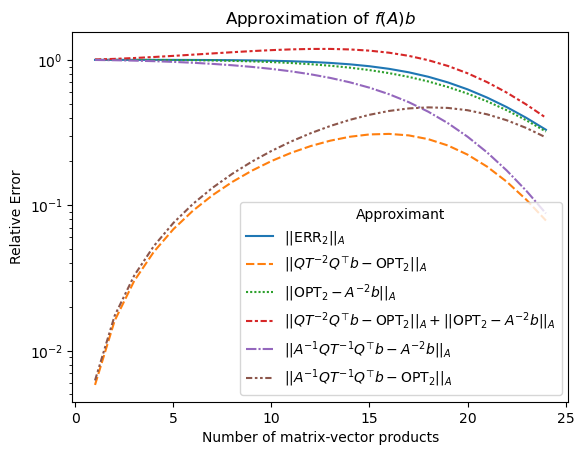

In [20]:
results_long = results.reset_index(names="Number of matrix-vector products").melt(
    id_vars=["Number of matrix-vector products"], value_name=error_label, var_name="Approximant")

sns.lineplot(x="Number of matrix-vector products", y=error_label, hue="Approximant", style="Approximant",
    data=results_long[results_long["Number of matrix-vector products"] <= 25]).set(
    title=f'Approximation of $f(A)b$',
    yscale='log'
);

plt.savefig('output/commutors.svg')

In [11]:
assert (results['$||A^{-1}QT^{-1}Q^\\top b - A^{-2}b||_A$'] 
    < results['$||\\mathrm{OPT}_2 - A^{-2}b||_A$']).all()

In [12]:
assert (results['$||A^{-1}QT^{-1}Q^\\top b - \\mathrm{OPT}_2||_A$'] 
    < results['$||\\mathrm{OPT}_2 - A^{-2}b||_A$']).all()

In [13]:
(results['$||\\mathrm{ERR}_2||_A$'] / results['$||\\mathrm{OPT}_2 - A^{-2}b||_A$']).max()

mpfr('1.07736632111094865155199028648545980983925287601335',169)

<AxesSubplot:>

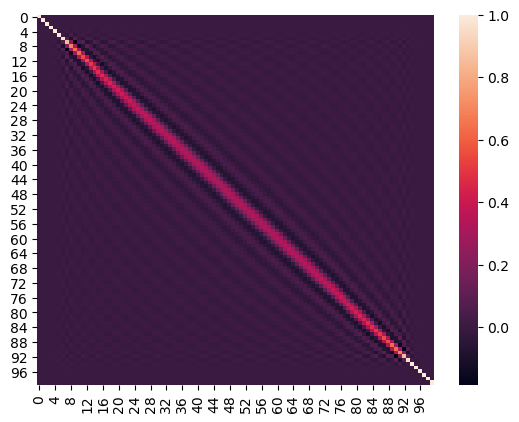

In [105]:
k = 50
Q, (alpha, beta) = mf.lanczos(A, b, k, reorthogonalize=True, beta_tol=flamp.to_mp("1e-20"))
T_lambda, T_V = mf.utils.eigh_tridiagonal(alpha, beta)
Q_TV = Q @ T_V
sns.heatmap((Q_TV @ Q_TV.transpose()).astype(float))

(0.0, 100.0)

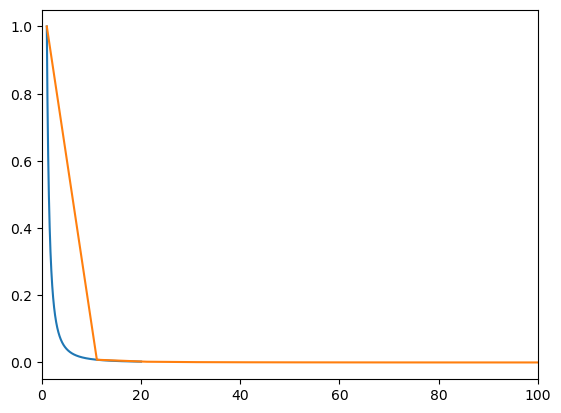

In [127]:
xxx = flamp.linspace(lambda_min, 20, 5000)
plt.plot(xxx, xxx**(-2))
plt.plot(a_diag, np.diag(Q_TV @ (mf.DiagonalMatrix(1./T_lambda) @ (Q_TV.transpose() @ np.diag(1./a_diag)))))

plt.xlim([0, 100])

In [88]:
err_mat = Q_TV @ (mf.DiagonalMatrix(f(T_lambda)) @ Q_TV.transpose()) - np.diag(f(A.diag))
# eigvals is vector of eigenvalues in no particular order
# columns of eigvecs is corresponding eigenvectors
eigvals, eigvecs = flamp.eigh(err_mat)

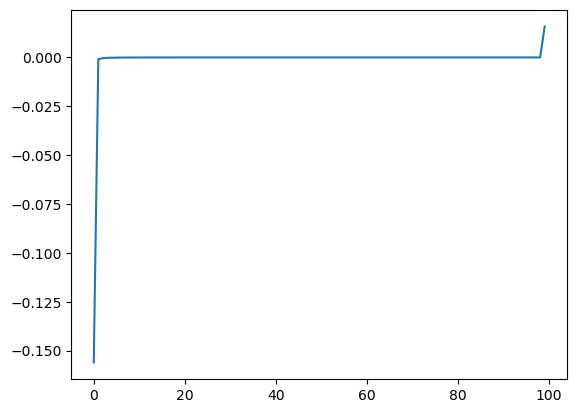

In [57]:
plt.plot(eigvals)

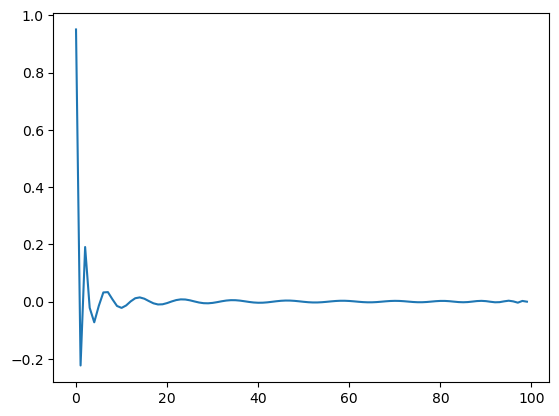

In [58]:
plt.plot(eigvecs[:, 0])

In [63]:
# Is A^{-1}b in the span of Q?
np.linalg.norm((invA @ b) - Q @ Q.transpose() @ (invA @ b), ord=np.inf)

mpfr('0.01873707471250094682070729842734286550130655404829665',169)

In [175]:
Q12, (alpha12, beta12) = mf.lanczos(A, b, k=None, reorthogonalize=True, beta_tol=flamp.to_mp("1e-20"))
T_lambda12, T_V12 = mf.utils.eigh_tridiagonal(alpha12, beta12)

In [176]:
Q1, (alpha1, beta1) = mf.lanczos(A, b, k=25, reorthogonalize=True, beta_tol=flamp.to_mp("1e-20"))
T_lambda1, T_V1 = mf.utils.eigh_tridiagonal(alpha1, beta1)